# Task 1: Exploratory Data Analysis and Data Preprocessing

**Objective**: Load, explore, filter, clean, and preprocess the CFPB complaints dataset for downstream NLP tasks.

**Dataset**: Consumer Financial Protection Bureau (CFPB) Complaints

**Author**: Data & AI Engineer

**Date**: 2026-01-06

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Dataset

Load the full CFPB complaints dataset from the `data/raw/` directory.

In [2]:
# Define file path
data_path = Path('../data/raw/')
csv_files = list(data_path.glob('*.csv'))

print(f"Found {len(csv_files)} CSV file(s) in data/raw/:")
for f in csv_files:
    print(f"  - {f.name}")

# Load the dataset (assuming the first CSV is the complaints dataset)
if csv_files:
    df_raw = pd.read_csv(csv_files[0], low_memory=False)
    print(f"\nDataset loaded: {csv_files[0].name}")
    print(f"Shape: {df_raw.shape}")
else:
    raise FileNotFoundError("No CSV files found in data/raw/. Please add the CFPB complaints dataset.")

Found 1 CSV file(s) in data/raw/:
  - complaints.csv

Dataset loaded: complaints.csv
Shape: (9609797, 18)


## 3. Initial Data Exploration

Examine the structure, columns, and basic statistics of the dataset.

In [3]:
# Display first few rows
print("First 5 rows:")
display(df_raw.head())

First 5 rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in the complaint,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [4]:
# Dataset info
print("Dataset Information:")
df_raw.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(1

In [5]:
# Check for missing values
print("Missing Values:")
missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum().values,
    'Missing_Percentage': (df_raw.isnull().sum().values / len(df_raw) * 100).round(2)
})
display(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

Missing Values:


,Column,Missing_Count,Missing_Percentage
10,Tags,8981029,93.46
16,Consumer disputed?,8841498,92.01
5,Consumer complaint narrative,6629041,68.98
6,Company public response,4770207,49.64
11,Consumer consent provided?,1649561,17.17
4,Sub-issue,839522,8.74
2,Sub-product,235295,2.45
8,State,54516,0.57
9,ZIP code,30228,0.31
14,Company response to consumer,20,0.00


In [6]:
# Identify the complaint narrative column
# Common column names: 'Consumer complaint narrative', 'Complaint', 'Consumer Complaint', etc.
narrative_cols = [col for col in df_raw.columns if 'narrative' in col.lower() or 'complaint' in col.lower()]
print(f"Potential narrative columns: {narrative_cols}")

# Identify the product column
product_cols = [col for col in df_raw.columns if 'product' in col.lower()]
print(f"Potential product columns: {product_cols}")

Potential narrative columns: ['Consumer complaint narrative', 'Complaint ID']
Potential product columns: ['Product', 'Sub-product']


## 4. Exploratory Data Analysis (EDA)

### 4.1 Distribution of Complaints by Product

Total unique products: 21

Top 15 Products by Complaint Count:


,Count
Product,
Credit reporting or other personal consumer reports,4834855
"Credit reporting, credit repair services, or other personal consumer reports",2163857
Debt collection,799197
Mortgage,422254
Checking or savings account,291178
Credit card,226686
Credit card or prepaid card,206369
"Money transfer, virtual currency, or money service",145066
Credit reporting,140429


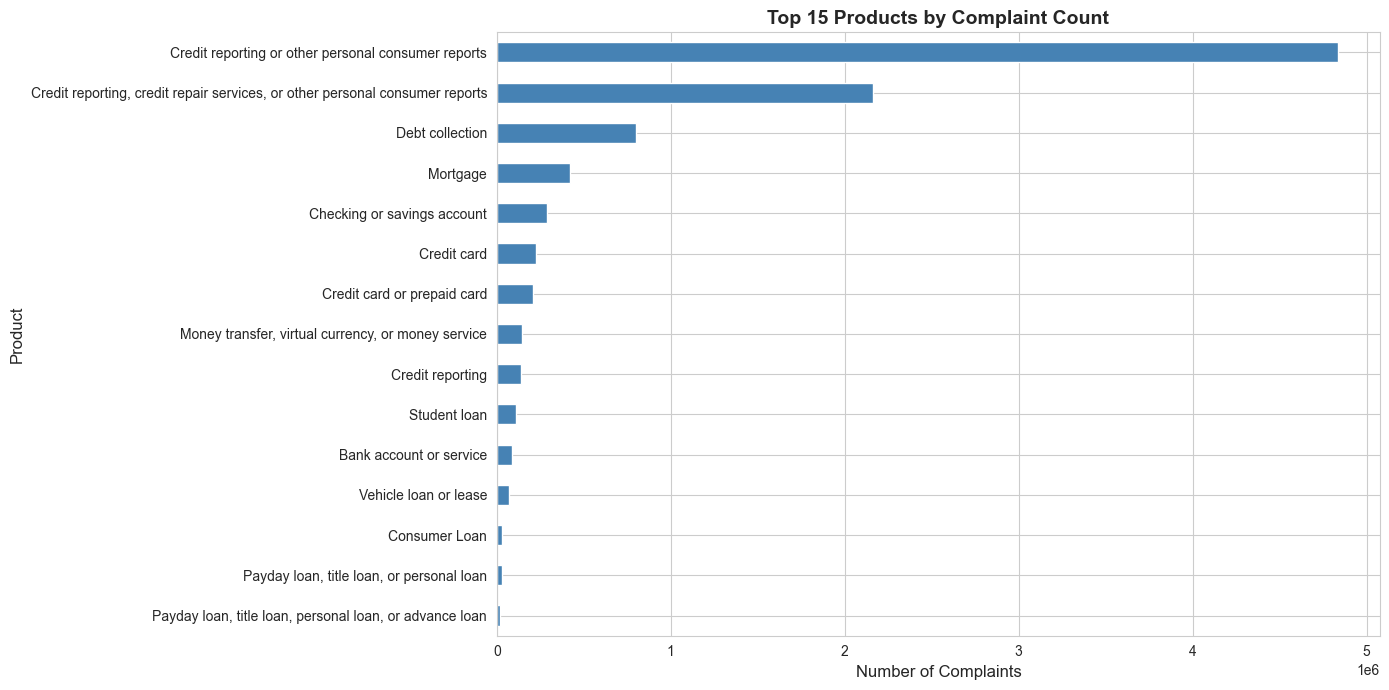

In [7]:
# Assuming the product column is named 'Product' (adjust if different)
product_col = 'Product' if 'Product' in df_raw.columns else product_cols[0] if product_cols else None

if product_col:
    # Count complaints by product
    product_counts = df_raw[product_col].value_counts()
    
    print(f"Total unique products: {len(product_counts)}")
    print(f"\nTop 15 Products by Complaint Count:")
    display(product_counts.head(15).to_frame(name='Count'))
    
    # Visualize top 15 products
    plt.figure(figsize=(14, 7))
    product_counts.head(15).plot(kind='barh', color='steelblue')
    plt.xlabel('Number of Complaints', fontsize=12)
    plt.ylabel('Product', fontsize=12)
    plt.title('Top 15 Products by Complaint Count', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Product column not found. Please verify the dataset structure.")

### 4.2 Count of Complaints With vs Without Consumer Complaint Narratives

Total Complaints: 9,609,797
With Narrative: 2,980,756 (31.02%)
Without Narrative: 6,629,041 (68.98%)


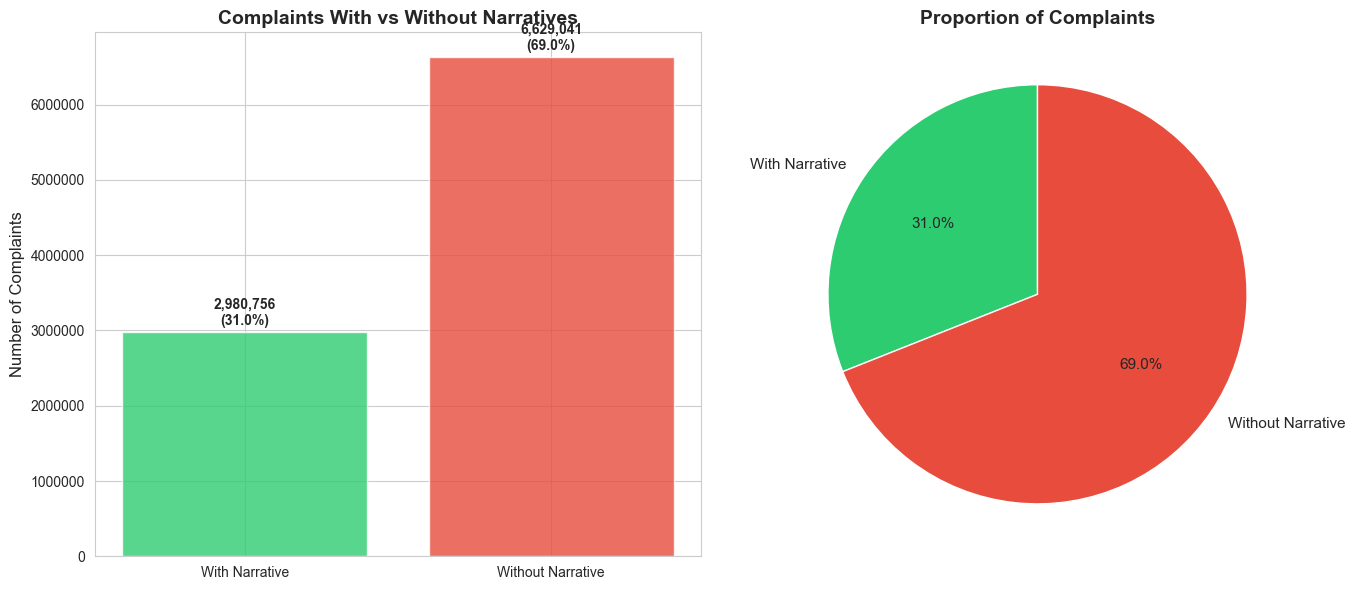

In [8]:
# Assuming the narrative column is named 'Consumer complaint narrative' (adjust if different)
narrative_col = 'Consumer complaint narrative' if 'Consumer complaint narrative' in df_raw.columns else narrative_cols[0] if narrative_cols else None

if narrative_col:
    # Count narratives
    has_narrative = df_raw[narrative_col].notna().sum()
    no_narrative = df_raw[narrative_col].isna().sum()
    total = len(df_raw)
    
    print(f"Total Complaints: {total:,}")
    print(f"With Narrative: {has_narrative:,} ({has_narrative/total*100:.2f}%)")
    print(f"Without Narrative: {no_narrative:,} ({no_narrative/total*100:.2f}%)")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart
    categories = ['With Narrative', 'Without Narrative']
    counts = [has_narrative, no_narrative]
    colors = ['#2ecc71', '#e74c3c']
    
    ax1.bar(categories, counts, color=colors, alpha=0.8)
    ax1.set_ylabel('Number of Complaints', fontsize=12)
    ax1.set_title('Complaints With vs Without Narratives', fontsize=14, fontweight='bold')
    ax1.ticklabel_format(style='plain', axis='y')
    
    for i, v in enumerate(counts):
        ax1.text(i, v + total*0.01, f'{v:,}\n({v/total*100:.1f}%)', ha='center', fontsize=10, fontweight='bold')
    
    # Pie chart
    ax2.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11})
    ax2.set_title('Proportion of Complaints', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Narrative column not found. Please verify the dataset structure.")

### 4.3 Word Count Distribution of Complaint Narratives

Analyze the length distribution of complaint narratives to understand text complexity.

Word Count Statistics:
Mean: 175.60
Median: 114.00
Std Dev: 225.93
Min: 1
Max: 6469
25th Percentile: 59.00
75th Percentile: 209.00


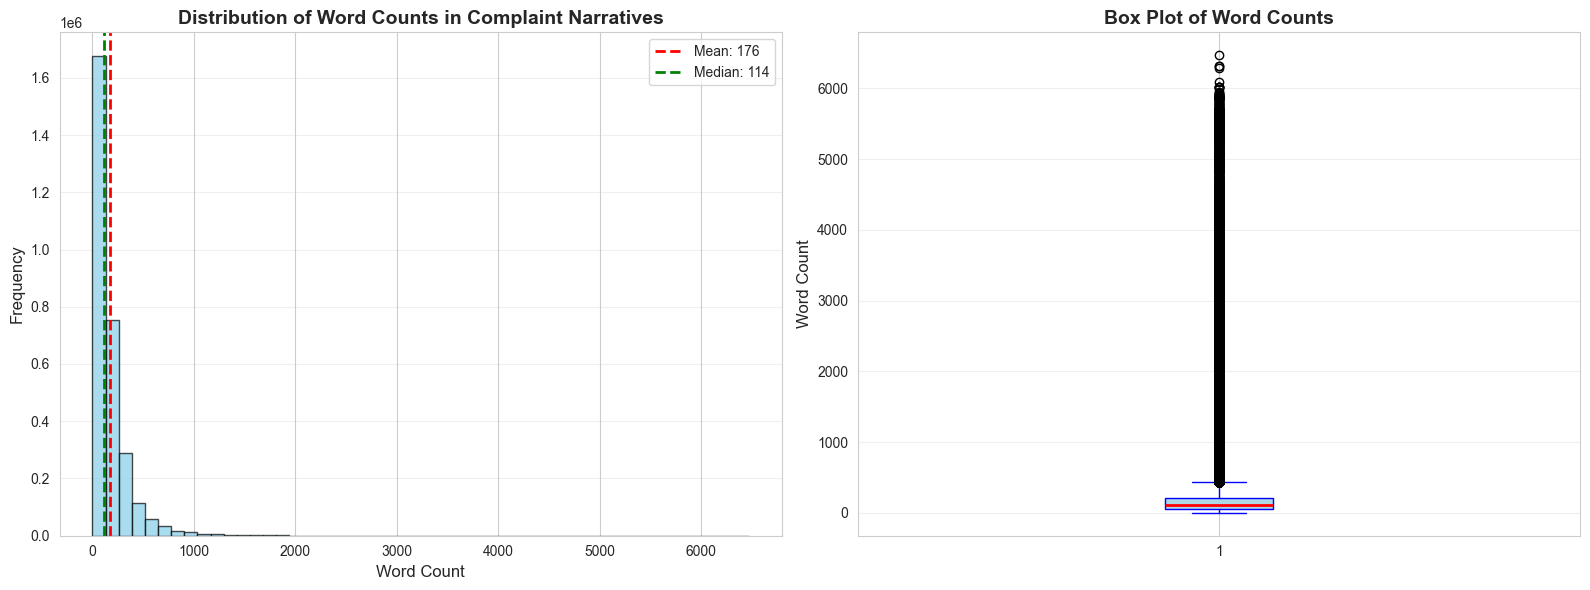


Narratives with < 10 words: 21,938 (0.74%)


In [9]:
if narrative_col:
    # Filter non-null narratives
    narratives = df_raw[df_raw[narrative_col].notna()][narrative_col]
    
    # Calculate word counts
    word_counts = narratives.apply(lambda x: len(str(x).split()))
    
    # Statistics
    print("Word Count Statistics:")
    print(f"Mean: {word_counts.mean():.2f}")
    print(f"Median: {word_counts.median():.2f}")
    print(f"Std Dev: {word_counts.std():.2f}")
    print(f"Min: {word_counts.min()}")
    print(f"Max: {word_counts.max()}")
    print(f"25th Percentile: {word_counts.quantile(0.25):.2f}")
    print(f"75th Percentile: {word_counts.quantile(0.75):.2f}")
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram
    axes[0].hist(word_counts, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {word_counts.mean():.0f}')
    axes[0].axvline(word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {word_counts.median():.0f}')
    axes[0].set_xlabel('Word Count', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Word Counts in Complaint Narratives', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot
    axes[1].boxplot(word_counts, vert=True, patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='blue'),
                    capprops=dict(color='blue'))
    axes[1].set_ylabel('Word Count', fontsize=12)
    axes[1].set_title('Box Plot of Word Counts', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: narratives with very few words
    short_narratives = (word_counts < 10).sum()
    print(f"\nNarratives with < 10 words: {short_narratives:,} ({short_narratives/len(word_counts)*100:.2f}%)")
else:
    print("Narrative column not found. Cannot analyze word counts.")

## 5. Data Filtering

Filter the dataset to include ONLY the following products:
- Credit card
- Personal loan
- Savings account
- Money transfer

In [10]:
if product_col:
    # Define target products (case-insensitive matching)
    target_products = ['Credit card', 'Personal loan', 'Savings account', 'Money transfer']
    
    # Check exact matches first
    print("Checking for exact product matches...")
    exact_matches = df_raw[product_col].isin(target_products)
    print(f"Exact matches found: {exact_matches.sum()}")
    
    # If no exact matches, try case-insensitive partial matching
    if exact_matches.sum() == 0:
        print("\nNo exact matches. Attempting case-insensitive partial matching...")
        print("\nAvailable products in dataset:")
        print(df_raw[product_col].unique()[:20])  # Show first 20 products
        
        # Create a filter using case-insensitive partial matching
        filter_mask = df_raw[product_col].str.lower().str.contains(
            '|'.join([p.lower() for p in target_products]), 
            na=False, 
            regex=True
        )
    else:
        filter_mask = exact_matches
    
    # Apply filter
    df_filtered = df_raw[filter_mask].copy()
    
    print(f"\nOriginal dataset size: {len(df_raw):,}")
    print(f"Filtered dataset size: {len(df_filtered):,}")
    print(f"Reduction: {(1 - len(df_filtered)/len(df_raw))*100:.2f}%")
    
    # Show distribution of filtered products
    print(f"\nProduct distribution after filtering:")
    display(df_filtered[product_col].value_counts().to_frame(name='Count'))
else:
    print("Product column not found. Cannot filter by product.")
    df_filtered = df_raw.copy()

Checking for exact product matches...
Exact matches found: 226686

Original dataset size: 9,609,797
Filtered dataset size: 226,686
Reduction: 97.64%

Product distribution after filtering:


,Count
Product,
Credit card,226686


## 6. Remove Rows with Empty or Null Narratives

Remove all rows where the consumer complaint narrative is empty or null.

In [11]:
if narrative_col:
    print(f"Before removing null narratives: {len(df_filtered):,} rows")
    
    # Remove null and empty narratives
    df_filtered = df_filtered[df_filtered[narrative_col].notna()].copy()
    df_filtered = df_filtered[df_filtered[narrative_col].str.strip() != ''].copy()
    
    print(f"After removing null narratives: {len(df_filtered):,} rows")
    print(f"Rows removed: {len(df_raw[filter_mask]) - len(df_filtered):,}")
else:
    print("Narrative column not found. Cannot remove null narratives.")

Before removing null narratives: 226,686 rows
After removing null narratives: 80,667 rows
Rows removed: 146,019


## 7. Text Cleaning and Preprocessing

Clean the complaint narratives by:
1. Converting to lowercase
2. Removing special characters and extra whitespace
3. Removing common boilerplate phrases

In [12]:
def clean_text(text):
    """
    Clean complaint narrative text.
    
    Args:
        text (str): Raw complaint text
    
    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ''
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove boilerplate phrases (case-insensitive)
    boilerplate_phrases = [
        r'i am writing to file a complaint',
        r'i am filing this complaint',
        r'i would like to file a complaint',
        r'i wish to file a complaint',
        r'this is a complaint regarding',
        r'i am submitting this complaint',
        r'dear sir or madam',
        r'to whom it may concern',
        r'dear cfpb',
    ]
    
    for phrase in boilerplate_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    
    # Remove special characters (keep letters, numbers, and spaces)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Test the cleaning function
sample_text = "I am writing to file a complaint about my Credit Card!! The company charged me $500.00 (unauthorized)."
print("Original text:")
print(sample_text)
print("\nCleaned text:")
print(clean_text(sample_text))

Original text:
I am writing to file a complaint about my Credit Card!! The company charged me $500.00 (unauthorized).

Cleaned text:
about my credit card the company charged me 500 00 unauthorized


In [13]:
if narrative_col:
    # Create a new column for cleaned narratives
    print("Cleaning complaint narratives...")
    df_filtered['cleaned_narrative'] = df_filtered[narrative_col].apply(clean_text)
    
    # Remove rows where cleaned narrative is empty
    initial_count = len(df_filtered)
    df_filtered = df_filtered[df_filtered['cleaned_narrative'].str.strip() != ''].copy()
    final_count = len(df_filtered)
    
    print(f"Rows removed after cleaning (empty after processing): {initial_count - final_count:,}")
    print(f"Final dataset size: {final_count:,}")
    
    # Show examples
    print("\n" + "="*80)
    print("SAMPLE BEFORE AND AFTER CLEANING")
    print("="*80)
    
    for i in range(min(3, len(df_filtered))):
        idx = df_filtered.index[i]
        print(f"\nExample {i+1}:")
        print("-" * 80)
        print("ORIGINAL:")
        print(df_filtered.loc[idx, narrative_col][:300] + "..." if len(df_filtered.loc[idx, narrative_col]) > 300 else df_filtered.loc[idx, narrative_col])
        print("\nCLEANED:")
        print(df_filtered.loc[idx, 'cleaned_narrative'][:300] + "..." if len(df_filtered.loc[idx, 'cleaned_narrative']) > 300 else df_filtered.loc[idx, 'cleaned_narrative'])
else:
    print("Narrative column not found. Cannot clean narratives.")

Cleaning complaint narratives...
Rows removed after cleaning (empty after processing): 0
Final dataset size: 80,667

SAMPLE BEFORE AND AFTER CLEANING

Example 1:
--------------------------------------------------------------------------------
ORIGINAL:
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unauthorized and not me. XXXX XXXX confirmed this was fraudulent and immediately closed the card. However...

CLEANED:
a xxxx xxxx card was opened under my name by a fraudster i received a notice from xxxx that an account was just opened under my name i reached out to xxxx xxxx to state that this activity was unauthorized and not me xxxx xxxx confirmed this was fraudulent and immediately closed the card however they...

Example 2:
--------------------------------------------------------------------------------
ORIGINAL:
Dear CFPB, I have a secure

## 8. Final Dataset Statistics

Summary statistics of the cleaned and filtered dataset.

In [14]:
print("FINAL DATASET SUMMARY")
print("="*80)
print(f"Total rows: {len(df_filtered):,}")
print(f"Total columns: {len(df_filtered.columns)}")
print(f"\nColumns: {list(df_filtered.columns)}")

if product_col:
    print(f"\nProduct Distribution:")
    display(df_filtered[product_col].value_counts().to_frame(name='Count'))

if 'cleaned_narrative' in df_filtered.columns:
    # Word count statistics for cleaned narratives
    cleaned_word_counts = df_filtered['cleaned_narrative'].apply(lambda x: len(str(x).split()))
    
    print(f"\nCleaned Narrative Word Count Statistics:")
    print(f"Mean: {cleaned_word_counts.mean():.2f}")
    print(f"Median: {cleaned_word_counts.median():.2f}")
    print(f"Std Dev: {cleaned_word_counts.std():.2f}")
    print(f"Min: {cleaned_word_counts.min()}")
    print(f"Max: {cleaned_word_counts.max()}")

print(f"\nMemory usage: {df_filtered.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

FINAL DATASET SUMMARY
Total rows: 80,667
Total columns: 19

Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'cleaned_narrative']

Product Distribution:


,Count
Product,
Credit card,80667



Cleaned Narrative Word Count Statistics:
Mean: 201.18
Median: 143.00
Std Dev: 221.64
Min: 2
Max: 6472

Memory usage: 256.07 MB


## 9. Save Cleaned Dataset

Save the cleaned and filtered dataset to `data/filtered_complaints.csv`.

In [15]:
# Define output path
output_path = Path('../data/filtered_complaints.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save to CSV
df_filtered.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")
print(f"File size: {output_path.stat().st_size / 1024**2:.2f} MB")
print(f"\nDataset shape: {df_filtered.shape}")
print(f"Columns saved: {list(df_filtered.columns)}")

Cleaned dataset saved to: ..\data\filtered_complaints.csv
File size: 190.65 MB

Dataset shape: (80667, 19)
Columns saved: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'cleaned_narrative']


## 10. Verification

Verify the saved dataset can be loaded correctly.

In [16]:
# Load the saved dataset
df_verify = pd.read_csv(output_path)

print("Verification:")
print(f"Loaded shape: {df_verify.shape}")
print(f"Original shape: {df_filtered.shape}")
print(f"Match: {df_verify.shape == df_filtered.shape}")

# Display first few rows
print("\nFirst 3 rows of saved dataset:")
display(df_verify.head(3))

print("\n" + "="*80)
print("TASK 1 COMPLETED SUCCESSFULLY")
print("="*80)

Verification:
Loaded shape: (80667, 19)
Original shape: (80667, 19)
Match: True

First 3 rows of saved dataset:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,cleaned_narrative
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX that an...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,a xxxx xxxx card was opened under my name by a fraudster i received a notice from xxxx that an a...
1,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I h...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,i have a secured credit card with citibank which is changed to unsecured card and i have been ca...
2,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,"I have a Citi rewards cards. The credit balance issued to me was {$8400.00}. I recently moved, w...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,i have a citi rewards cards the credit balance issued to me was 8400 00 i recently moved which m...



TASK 1 COMPLETED SUCCESSFULLY
